# 1. 📦 Import Libraries


In [1]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
import seaborn as sns
import requests
from io import StringIO
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer


# 2. 🌐 Load Dataset



In [2]:
url = "https://raw.githubusercontent.com/susanli2016/PyCon-Canada-2019-NLP-Tutorial/master/bbc-text.csv"
response = requests.get(url)
data = pd.read_csv(StringIO(response.text))

In [3]:
print(f"Dataset shape: {data.shape}")
print(data['category'].value_counts())

Dataset shape: (2225, 2)
category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64


# 3. 🧪 Sample 100 Articles
### To keep the processing light and balanced

In [4]:
sample_size = 100
data_sample = data.groupby('category').apply(lambda x: x.sample(min(len(x), sample_size//5))).reset_index(drop=True)


<ipython-input-4-efe0a684d1d7>:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  data_sample = data.groupby('category').apply(lambda x: x.sample(min(len(x), sample_size//5))).reset_index(drop=True)


# 4. ✂️ Preprocess Texts
### Keep only the first 20 words of each article (just enough to capture context, not too long).

### Convert into a list of short summaries.


In [5]:
texts = data_sample['text'].str.split().str[:20].str.join(' ').tolist()  # Get first 20 words
categories = data_sample['category'].tolist()

# 5. 🤖 Generate Sentence Embeddings ( semantic meaning )

In [6]:
print("Creating embeddings...")
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')  # A good model for semantic similarity
embeddings = model.encode(texts, show_progress_bar=True)

Creating embeddings...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.51k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

# 6. 🔍 Find Optimal Number of Clusters

In [7]:
def find_optimal_clusters(embeddings, max_clusters=10):
    silhouette_scores = []
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(embeddings)
        silhouette_avg = silhouette_score(embeddings, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        print(f"Silhouette score for {n_clusters} clusters: {silhouette_avg:.3f}")

    return silhouette_scores

In [8]:
silhouette_scores = find_optimal_clusters(embeddings)
optimal_clusters = np.argmax(silhouette_scores) + 2  # +2 because we start from 2 clusters
print(f"Optimal number of clusters: {optimal_clusters}")

Silhouette score for 2 clusters: 0.037
Silhouette score for 3 clusters: 0.029
Silhouette score for 4 clusters: 0.018
Silhouette score for 5 clusters: 0.018
Silhouette score for 6 clusters: 0.018
Silhouette score for 7 clusters: 0.016
Silhouette score for 8 clusters: 0.021
Silhouette score for 9 clusters: 0.021
Silhouette score for 10 clusters: 0.022
Optimal number of clusters: 2


In [9]:
num_clusters = optimal_clusters

# 7. 🧠 Apply KMeans Clustering

In [10]:
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(embeddings)

# 8. 🗺️ Visualize Clusters with t-SNE

### t-SNE reduces embeddings to 2D for visualization.


In [11]:
print("Reducing dimensions for visualization...")
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(texts)-1))
embeddings_2d = tsne.fit_transform(embeddings)


Reducing dimensions for visualization...


In [12]:
df_plot = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'cluster': clusters,
    'category': categories,
    'text': texts
})


Text(0, 0.5, 't-SNE Dimension 2')

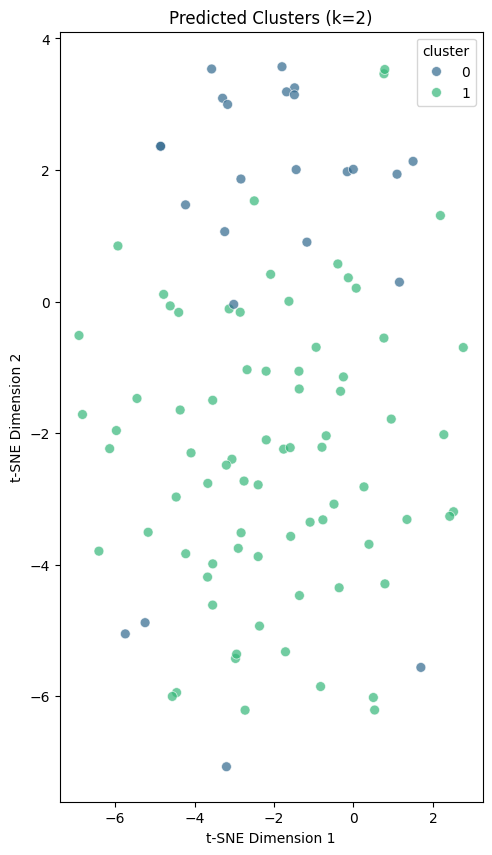

In [13]:
plt.figure(figsize=(12, 10))
plt.subplot(1, 2, 1)
sns.scatterplot(data=df_plot, x='x', y='y', hue='cluster', palette='viridis', s=50, alpha=0.7)
plt.title(f"Predicted Clusters (k={num_clusters})")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

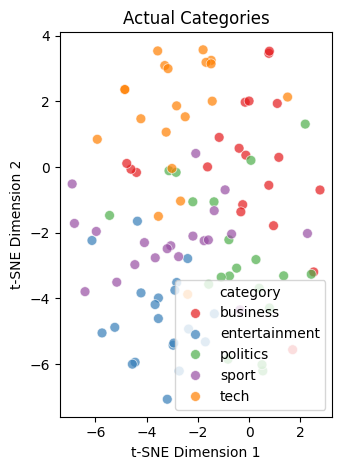

In [14]:
plt.subplot(1, 2, 2)
sns.scatterplot(data=df_plot, x='x', y='y', hue='category', palette='Set1', s=50, alpha=0.7)
plt.title("Actual Categories")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")

plt.tight_layout()

In [15]:
le = LabelEncoder()
true_labels = le.fit_transform(categories)

# 9. 📏 Evaluate Clustering Quality


In [16]:
ari = adjusted_rand_score(true_labels, clusters)
nmi = normalized_mutual_info_score(true_labels, clusters, average_method='arithmetic')

In [17]:
print(f"Adjusted Rand Index: {ari:.3f}")
print(f"Normalized Mutual Information: {nmi:.3f}")

Adjusted Rand Index: 0.097
Normalized Mutual Information: 0.215


# 10. 📊 Show Cluster Composition

In [18]:
cluster_df = pd.DataFrame({'text': texts, 'predicted_cluster': clusters, 'true_category': categories})
cluster_composition = pd.crosstab(cluster_df['predicted_cluster'], cluster_df['true_category'],
                                 normalize='index')
print("\nCluster Composition (%):")
print(cluster_composition * 100)


Cluster Composition (%):
true_category       business  entertainment   politics      sport       tech
predicted_cluster                                                           
0                  25.000000      12.500000   0.000000   0.000000  62.500000
1                  18.421053      22.368421  26.315789  26.315789   6.578947


# 11. 📚 Show Example Articles per Cluster


In [19]:
def get_cluster_examples(df, cluster_id, n=3):
    cluster_texts = df[df['predicted_cluster'] == cluster_id]['text'].tolist()
    cluster_categories = df[df['predicted_cluster'] == cluster_id]['true_category'].tolist()
    return list(zip(cluster_texts, cluster_categories))[:n]


In [20]:
print("\nRepresentative examples from each cluster:")
for i in range(num_clusters):
    examples = get_cluster_examples(cluster_df, i)
    print(f"\nCluster {i}:")
    for text, category in examples:
        print(f"[{category}] {text[:100]}...")



Representative examples from each cluster:

Cluster 0:
[business] wipro beats forecasts once again wipro india s third-biggest software firm has reported a 60% rise i...
[business] india power shares jump on debut shares in india s largest power producer national thermal power cor...
[business] telegraph newspapers axe 90 jobs the daily and sunday telegraph newspapers are axing 90 journalist j...

Cluster 1:
[business] fannie mae should restate books us mortgage company fannie mae should restate its earnings a move th...
[business] dollar gains on greenspan speech the dollar has hit its highest level against the euro in almost thr...
[business] yukos bankruptcy not us matter russian authorities do not have to abide by any us court decisions ta...


# 12. 🔑 Extract Keywords per Cluster

In [21]:
def get_cluster_keywords(texts, clusters, n_clusters, top_n=5):
    keywords = {}
    for i in range(n_clusters):
        cluster_texts = [texts[j] for j in range(len(texts)) if clusters[j] == i]
        if not cluster_texts:
            continue

        # Compute TF-IDF
        vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
        tfidf_matrix = vectorizer.fit_transform(cluster_texts)
        feature_names = vectorizer.get_feature_names_out()

        # Get top terms
        avg_tfidf = np.array(tfidf_matrix.mean(axis=0)).flatten()
        top_indices = avg_tfidf.argsort()[-top_n:][::-1]
        keywords[i] = [feature_names[idx] for idx in top_indices]

    return keywords

In [22]:
cluster_keywords = get_cluster_keywords(texts, clusters, num_clusters)
print("\nKeywords for each cluster:")
for cluster_id, words in cluster_keywords.items():
    print(f"Cluster {cluster_id}: {', '.join(words)}")


Keywords for each cluster:
Cluster 0: broadband, uk, tv, software, music
Cluster 1: world, union, new, bid, yukos


# This pipeline shows how to:

- Automatically group similar documents (unsupervised learning)

- Use embeddings for meaningful comparison

- Visualize and interpret clusters

- Compare clustering results with ground truth (labels)